# Simulator Analysis

This note outlines how we can use Plausible Log-likelihood Score to 'debug' what might be wrong with the simulator by visualising trajectories with low PLS and comparing it to simulator trajectories.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
results = pd.read_csv('../gms-glucose-diab-missing-run8/output.csv')

In [3]:
results.sort_values(by=['test loss'], inplace=True)
results.head()

,simulator name,test loss
7,vent_minus1,2.031938
5,vaso_minus2,2.040358
10,antibiotic_minus1,2.049158
11,real,2.055271
0,vent1,2.056325


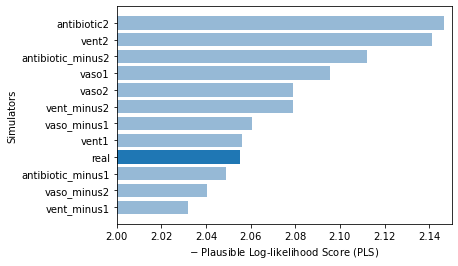

In [22]:
#8dc3f0
%matplotlib inline
mask = results['simulator name'] == 'real'
plt.barh(results['simulator name'], results['test loss'], color='#96b9d6')
plt.barh(results['simulator name'][mask], results['test loss'][mask])
plt.xlabel('$-$ Plausible Log-likelihood Score (PLS)')
plt.ylabel('Simulators')
plt.xlim([2.00, 2.15])
plt.show()

In [5]:
import glob
import re
filename = 'validation-loss.csv'
all_filenames = [i for i in glob.glob('/data/localhost/taufiq/gms-glucose-diab-missing-run8/gms-run8-sim_*/{}'.format(filename))]


In [6]:
val_losses = pd.DataFrame(columns=['simulator name', 'test loss'])
for path in all_filenames:
    sim_name = re.search('/data/localhost/taufiq/gms-glucose-diab-missing-run8/gms-run8-sim_(.+?)/validation-loss.csv', path).group(1)
    df = pd.read_csv(path)
    test_loss = df['Test Loss'].values[-1]
    val_losses = val_losses.append({'simulator name': sim_name, 'test loss': test_loss}, ignore_index=True)

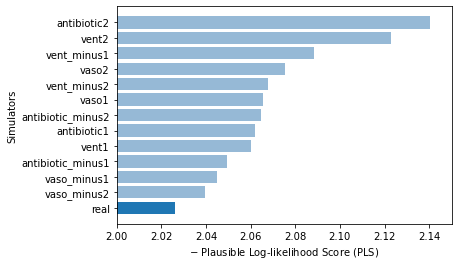

In [23]:
val_losses.sort_values(by=['test loss'], inplace=True)
%matplotlib inline
mask = val_losses['simulator name'] == 'real'
plt.barh(val_losses['simulator name'], val_losses['test loss'], color='#96b9d6')
plt.barh(val_losses['simulator name'][mask], val_losses['test loss'][mask])
plt.xlabel('$-$ Plausible Log-likelihood Score (PLS)')
plt.ylabel('Simulators')
plt.xlim([2.00, 2.15])
plt.show()

In [5]:
val_data = pd.read_csv('/data/localhost/taufiq/sontag-sim-validation-data/data.csv')

In [6]:
val_data.head()

,hr_state,sysbp_state,percoxyg_state,glucose_state,antibiotic_state,vaso_state,vent_state,diabetic_idx,id,A_t,t
0,2,2,1,0,0,0,0,0,0,6,0
1,2,1,1,1,1,0,1,0,0,6,1
2,1,1,1,1,1,0,1,0,0,4,2
3,1,1,1,1,1,0,0,0,0,4,3
4,1,1,0,1,1,0,0,0,0,4,4


In [26]:
from pyroapi import distributions as dist
from pyroapi import handlers, infer, optim, pyro, pyro_backend
from pyro.infer.autoguide import AutoDelta
from pyro.optim import ClippedAdam
from pyro.ops.indexing import Vindex
from pyro.util import ignore_jit_warnings
import pyro.contrib.examples.polyphonic_data_loader as poly
from gumbel_max_sim.GumbelMaxModel import GumbelMaxModel
from gumbel_max_sim.utils.ObservationalDataset import ObservationalDataset, cols
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro import poutine
import torch

from gumbel_max_sim.utils.State import State
from gumbel_max_sim.utils.Action import Action
from gumbel_max_sim.utils.Simulators import *

In [8]:
from tqdm import tqdm

def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    losses = pd.DataFrame()
    # compute the loss over the entire test set
    for mini_batch, actions, lengths in tqdm(test_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            mini_batch = mini_batch.cuda()
            actions = actions.cuda()
            lengths = lengths.cuda()
        mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths \
            = poly.get_mini_batch(torch.arange(mini_batch.size(0)), mini_batch, lengths, cuda=use_cuda)
        # compute ELBO estimate and accumulate loss
        test_loss = svi.evaluate_loss(
            mini_batch.float(), actions.float(), mini_batch_mask.float(), mini_batch_seq_lengths, mini_batch_reversed.float()
        )
        losses = losses.append({'id': mini_batch[0,0,-1].item(), 'test loss': test_loss}, ignore_index=True)
    normalizer_test = len(test_loader.dataset)
    return losses

In [9]:
def simulator_validation_losses(simulator_name, model_path, data_path):
    gumbel_model = GumbelMaxModel(simulator_name=simulator_name)
    gumbel_model.load_state_dict(torch.load(model_path))
    gumbel_model.eval()
    optimizer = ClippedAdam({})
    elbo = TraceEnum_ELBO(max_plate_nesting=2, strict_enumeration_warning=True)
    guide = AutoDelta(poutine.block(gumbel_model.model))
    svi = SVI(gumbel_model.model, guide, optimizer, elbo)
    observational_dataset = ObservationalDataset(data_path, xt_columns=cols + ['id'], action_columns=["A_t"])
    validation_loader = torch.utils.data.DataLoader(observational_dataset, batch_size=1)
    losses = evaluate(svi, validation_loader)
    losses.sort_values(by='test loss', ascending=False, inplace=True)
    return losses

In [15]:
path = '/data/localhost/taufiq/sontag-sim-validation-data/data.csv'
model_path = '/data/localhost/taufiq/gms-glucose-diab-missing-run6/gms-run6-sim_antibiotic2/model-state-final'
simulator_name = 'antibiotic2'

In [16]:
losses = simulator_validation_losses(simulator_name, model_path, path)

100%|██████████| 2000/2000 [10:30<00:00,  3.17it/s]


In [17]:
losses.head()

,id,test loss
966,966.0,30.575035
1928,1928.0,29.237177
777,777.0,25.918230
1606,1606.0,25.905191
1355,1355.0,25.770939


In [14]:
columns = ['hr_state', 'sysbp_state', 'percoxyg_state', 'antibiotic_state', 'vaso_state', 'vent_state']
def plot_trajectory(trajectories):
    eps = 0.5
    param_dict = {
        'hr_state': {
            'ticks': ['Low', 'Normal', 'High'],
            'vals': [0, 1, 2],
            'nrange': [0.75, 1.25],
            'ylabel': 'HR'
        },
        'sysbp_state': {
            'ticks': ['Low', 'Normal', 'High'],
            'vals': [0, 1, 2],
            'nrange': [0.75, 1.25],
            'ylabel': 'SysBP'
        },
        'percoxyg_state': {
            'ticks': ['Low', 'Normal'],
            'vals': [0, 1],
            'nrange': [0.75, 1.25],
            'ylabel': 'Pct O2'
        },
        'glucose_state': {
            'ticks': ['V. Low', 'Low', 'Normal', 'High', 'V. High'],
            'vals': [0, 1, 2, 3, 4],
            'nrange': [1.75, 2.25],
            'ylabel': 'Glucose'
        },
        'antibiotic_state': {
            'ticks': ['Off', 'On'],
            'vals': [0, 1],
            'nrange': None,
            'ylabel': 'Tx: Abx'
        },
        'vaso_state':{
            'ticks': ['Off', 'On'],
            'vals': [0, 1],
            'nrange': None,
            'ylabel': 'Tx: Vaso'
        },
        'vent_state': {
            'ticks': ['Off', 'On'],
            'vals': [0, 1],
            'nrange': None,
            'ylabel': 'Tx: Vent'
        },
    }
    fig, axes = plt.subplots(6, 1, sharex=True)
    fig.set_size_inches(8, 10)
    for i in range(6):
        this_col = columns[i]
        axes[i].plot(trajectories[0]['t'], trajectories[0][this_col], color='k')
        if i < 3:
            for j in range(1, len(trajectories)):
                axes[i].plot(trajectories[j]['t'], trajectories[j][this_col], color='b')
            axes[i].legend(['real', 'simulated'])

        # Format the Y-axis according to the variable
        axes[i].set_ylabel(param_dict[this_col]['ylabel'])
        axes[i].set_yticks(param_dict[this_col]['vals'])
        axes[i].set_yticklabels(param_dict[this_col]['ticks'])
        axes[i].set_ylim(param_dict[this_col]['vals'][0] - eps,
                         param_dict[this_col]['vals'][-1]+ eps)
        nrange = param_dict[this_col]['nrange']
        
        last_time = trajectories[0].shape[0]
        axes[i].set_xlim(-0.25, last_time + 0.5)
        # Format the X-axis as integers
        axes[i].xaxis.set_ticks(np.arange(0, last_time + 2, 2))
        axes[i].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    return fig, axes


In [24]:
@infer_discrete(first_available_dim=-1, temperature=0)
@config_enumerate
def infer_initial_state(model, trajectory):
    with torch.no_grad():
        s0_diab = pyro.sample(
                    f"s0_diab_state",
                    dist.Categorical(logits=model.s0_diab_logits)
                )
        s0_hr = pyro.sample(
                    f"s0_hr",
                    dist.Categorical(logits=Vindex(model.s0_hr)[s0_diab, :]),
                    obs = torch.FloatTensor(trajectory.loc[trajectory['t'] == 0, 'hr_state'].values)
                )
        s0_sysbp = pyro.sample(
                    f"s0_sysbp",
                    dist.Categorical(logits=Vindex(model.s0_sysbp)[s0_diab, :]),
                    obs = torch.FloatTensor(trajectory.loc[trajectory['t'] == 0, 'sysbp_state'].values)
                )
        s0_glucose = pyro.sample(
                    f"s0_glucose",
                    dist.Categorical(logits=Vindex(model.s0_glucose)[s0_diab, :])
                )
        s0_percoxyg = pyro.sample(
                    f"s0_percoxyg",
                    dist.Categorical(logits=Vindex(model.s0_percoxyg)[s0_diab, :]),
                    obs = torch.FloatTensor(trajectory.loc[trajectory['t'] == 0, 'percoxyg_state'].values)
                )
    return s0_diab, s0_hr, s0_sysbp, s0_glucose, s0_percoxyg

In [23]:
def plot_real_vs_simulated(simulator_model, val_data, pt_id, n_iters=1):
    trajectory = val_data[(val_data['id']==pt_id) & (val_data['hr_state'] != -1)]
    simulator_trajectories = []
    for i in range(n_iters):
        s0_diab, s0_hr, s0_sysbp, s0_glucose, s0_percoxyg = infer_initial_state(simulator_model, trajectory)
        mask = torch.ones((1, len(trajectory)+1))
        with torch.no_grad():
            a_prev = Action(action_idx=torch.zeros((1)))
            st = State(hr_state=s0_hr, sysbp_state=s0_sysbp, percoxyg_state=s0_percoxyg, glucose_state=s0_glucose, antibiotic_state=a_prev.antibiotic, vaso_state=a_prev.vasopressors, vent_state=a_prev.ventilation, diabetic_idx=s0_diab)
            mdp = get_simulator('antibiotic2', st, 'cpu')
            simulator_trajectory = pd.DataFrame()
            simulator_trajectory = simulator_trajectory.append({'t':0, 'id': trajectory['id'].values[0], 'hr_state': st.hr_state.item(), 'sysbp_state': st.sysbp_state.item(), 'percoxyg_state': st.percoxyg_state.item(), 'antibiotic_state': st.antibiotic_state.item(), 'vaso_state': st.vaso_state.item(), 'vent_state': st.vent_state.item()}, ignore_index=True)
            t = 0
            for index, row in trajectory.iterrows():
                if trajectory.at[index, 'A_t'] == -1:
                    break
                action = Action(torch.Tensor([trajectory.at[index, 'A_t']]))
                mdp.transition(action, mask, t+1)
                simulator_trajectory = simulator_trajectory.append({'t':t+1, 'id': trajectory['id'].values[0], 'hr_state': st.hr_state.item(), 'sysbp_state': st.sysbp_state.item(), 'percoxyg_state': st.percoxyg_state.item(), 'antibiotic_state': st.antibiotic_state.item(), 'vaso_state': st.vaso_state.item(), 'vent_state': st.vent_state.item()}, ignore_index=True)
                t += 1
        simulator_trajectories.append(simulator_trajectory)
    fig, axes = plot_trajectory([trajectory]+simulator_trajectories)

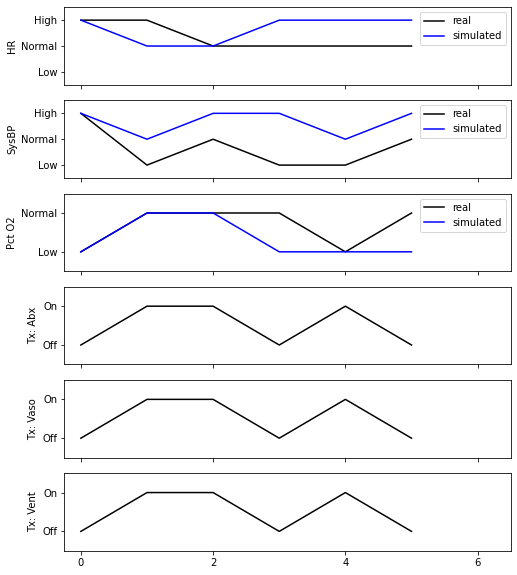

In [24]:
gumbel_model = GumbelMaxModel(simulator_name=simulator_name)
gumbel_model.load_state_dict(torch.load(model_path))
gumbel_model.eval()
plot_real_vs_simulated(gumbel_model, val_data, 1928)

In [19]:
def get_simulated_trajectories(simulator_model, val_data, pt_id, n_iters=100):
    trajectory = val_data[(val_data['id']==pt_id) & (val_data['hr_state'] != -1)]
    simulator_trajectories = []
    for i in tqdm(range(n_iters)):
        s0_diab, s0_hr, s0_sysbp, s0_glucose, s0_percoxyg = infer_initial_state(simulator_model, trajectory)
        mask = torch.ones((1, len(trajectory)+1))
        with torch.no_grad():
            a_prev = Action(action_idx=torch.zeros((1)))
            st = State(hr_state=s0_hr, sysbp_state=s0_sysbp, percoxyg_state=s0_percoxyg, glucose_state=s0_glucose, antibiotic_state=a_prev.antibiotic, vaso_state=a_prev.vasopressors, vent_state=a_prev.ventilation, diabetic_idx=s0_diab)
            mdp = get_simulator('antibiotic2', st, 'cpu')
            simulator_trajectory = pd.DataFrame()
            simulator_trajectory = simulator_trajectory.append({'t':0, 'id': trajectory['id'].values[0], 'hr_state': st.hr_state.item(), 'sysbp_state': st.sysbp_state.item(), 'percoxyg_state': st.percoxyg_state.item(), 'antibiotic_state': st.antibiotic_state.item(), 'vaso_state': st.vaso_state.item(), 'vent_state': st.vent_state.item()}, ignore_index=True)
            t = 0
            for index, row in trajectory.iterrows():
                if trajectory.at[index, 'A_t'] == -1:
                    break
                action = Action(torch.Tensor([trajectory.at[index, 'A_t']]))
                mdp.transition(action, mask, t+1)
                simulator_trajectory = simulator_trajectory.append({'t':t+1, 'id': trajectory['id'].values[0], 'hr_state': st.hr_state.item(), 'sysbp_state': st.sysbp_state.item(), 'percoxyg_state': st.percoxyg_state.item(), 'antibiotic_state': st.antibiotic_state.item(), 'vaso_state': st.vaso_state.item(), 'vent_state': st.vent_state.item()}, ignore_index=True)
                t += 1
        simulator_trajectories.append(simulator_trajectory)
    return simulator_trajectories

In [26]:
sim_trajectories = get_simulated_trajectories(gumbel_model, val_data, 1928)

100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


In [20]:
def get_aggregate_of_trajectories(simulator_trajectories):    
    mean = pd.DataFrame()
    mean['t'] = simulator_trajectories[0]['t']
    mean[['hr_state', 'sysbp_state', 'percoxyg_state']] = 0
    
    error = pd.DataFrame()
    error['t'] = simulator_trajectories[0]['t']
    error[['hr_state', 'sysbp_state', 'percoxyg_state']] = 0
    
    for trajectory in simulator_trajectories:
        mean[['hr_state', 'sysbp_state', 'percoxyg_state']] += trajectory[['hr_state', 'sysbp_state', 'percoxyg_state']]
        error[['hr_state', 'sysbp_state', 'percoxyg_state']] += trajectory[['hr_state', 'sysbp_state', 'percoxyg_state']]**2
        
    mean[['hr_state', 'sysbp_state', 'percoxyg_state']] /= len(simulator_trajectories)
    error[['hr_state', 'sysbp_state', 'percoxyg_state']] /= len(simulator_trajectories)
    error[['hr_state', 'sysbp_state', 'percoxyg_state']] -= mean[['hr_state', 'sysbp_state', 'percoxyg_state']]**2
    error[['hr_state', 'sysbp_state', 'percoxyg_state']] = np.sqrt(error[['hr_state', 'sysbp_state', 'percoxyg_state']])
    return mean, error

In [56]:
mean, error = get_aggregate_of_trajectories(sim_trajectories)

In [21]:
def plot_real_trajectory_vs_simulated_trajectories(real_trajectory, sim_mean, sim_error):
    columns = ['hr_state', 'sysbp_state', 'percoxyg_state', 'antibiotic_state', 'vaso_state', 'vent_state']
    eps = 0.5
    param_dict = {
        'hr_state': {
            'ticks': ['Low', 'Normal', 'High'],
            'vals': [0, 1, 2],
            'nrange': [0.75, 1.25],
            'ylabel': 'HR'
        },
        'sysbp_state': {
            'ticks': ['Low', 'Normal', 'High'],
            'vals': [0, 1, 2],
            'nrange': [0.75, 1.25],
            'ylabel': 'SysBP'
        },
        'percoxyg_state': {
            'ticks': ['Low', 'Normal'],
            'vals': [0, 1],
            'nrange': [0.75, 1.25],
            'ylabel': 'Pct O2'
        },
        'glucose_state': {
            'ticks': ['V. Low', 'Low', 'Normal', 'High', 'V. High'],
            'vals': [0, 1, 2, 3, 4],
            'nrange': [1.75, 2.25],
            'ylabel': 'Glucose'
        },
        'antibiotic_state': {
            'ticks': ['Off', 'On'],
            'vals': [0, 1],
            'nrange': None,
            'ylabel': 'Tx: Abx'
        },
        'vaso_state':{
            'ticks': ['Off', 'On'],
            'vals': [0, 1],
            'nrange': None,
            'ylabel': 'Tx: Vaso'
        },
        'vent_state': {
            'ticks': ['Off', 'On'],
            'vals': [0, 1],
            'nrange': None,
            'ylabel': 'Tx: Vent'
        },
    }
    fig, axes = plt.subplots(6, 1, sharex=True)
    fig.set_size_inches(8, 10)
    for i in range(6):
        this_col = columns[i]
        axes[i].plot(real_trajectory['t'], real_trajectory[this_col], color='k')
        if i < 3:
            axes[i].plot(sim_mean['t'], sim_mean[this_col], color='b')
            axes[i].legend(['real', 'simulated'])
            axes[i].fill_between(sim_mean['t'], 
                                 sim_mean[this_col]-sim_error[this_col], 
                                 sim_mean[this_col]+sim_error[this_col],
                                 facecolor='#cae5fa')

        # Format the Y-axis according to the variable
        axes[i].set_ylabel(param_dict[this_col]['ylabel'])
        axes[i].set_yticks(param_dict[this_col]['vals'])
        axes[i].set_yticklabels(param_dict[this_col]['ticks'])
        axes[i].set_ylim(param_dict[this_col]['vals'][0] - eps,
                         param_dict[this_col]['vals'][-1]+ eps)
        nrange = param_dict[this_col]['nrange']
        
        last_time = real_trajectory.shape[0]
        axes[i].set_xlim(-0.25, last_time + 0.5)
        # Format the X-axis as integers
        axes[i].xaxis.set_ticks(np.arange(0, last_time + 2, 2))
        axes[i].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    return fig, axes


In [28]:
def generate_diagnosis_plots(val_data, pt_id, simulator_name, model_path):
    gumbel_model = GumbelMaxModel(simulator_name=simulator_name)
    gumbel_model.load_state_dict(torch.load(model_path))
    gumbel_model.eval()
    trajectory = val_data[(val_data['id']==pt_id) & (val_data['hr_state'] != -1)]
    simulated_trajectories = get_simulated_trajectories(gumbel_model, val_data, pt_id, n_iters=100)
    mean, error = get_aggregate_of_trajectories(simulated_trajectories)
    fig, axes = plot_real_trajectory_vs_simulated_trajectories(trajectory, mean, error)

100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


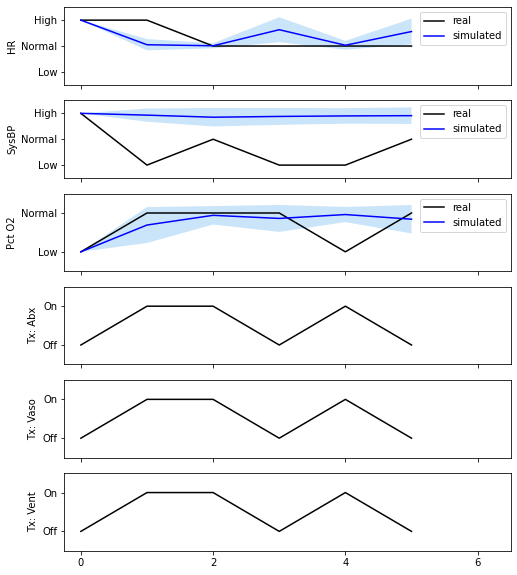

In [75]:
pt_id = 1928
model_path = '/data/localhost/taufiq/gms-glucose-diab-missing-run6/gms-run6-sim_antibiotic2/model-state-final'
simulator_name = 'antibiotic2'
generate_diagnosis_plots(val_data, pt_id, simulator_name, model_path)

In [18]:
losses.tail()

,id,test loss
887,887.0,4.041837
788,788.0,4.037643
1136,1136.0,3.634146
1292,1292.0,3.561984
1190,1190.0,3.462439


100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


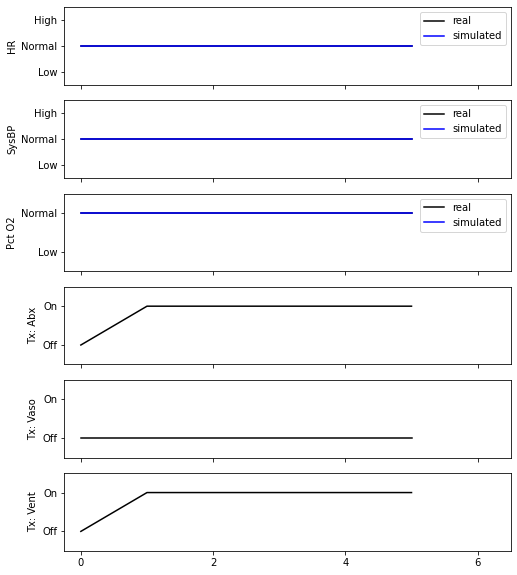

In [31]:
pt_id = 1136
model_path = '/data/localhost/taufiq/gms-glucose-diab-missing-run6/gms-run6-sim_antibiotic2/model-state-final'
simulator_name = 'antibiotic2'
generate_diagnosis_plots(val_data, pt_id, simulator_name, model_path)